# Identity Mining 

We will build identity mining tool for the corpus related to depression. 

## Dataset 

First we will start with the MyPersonality dataset with CES-D score. 

### Data cleaning

Let's clean the cesd_item_level.csv.   We will do 
* Arrange the answers according to the question numbers 
* Add the total score and verify with 939_userScores.csv 
* We will filter the data so that it contains only 939 data points, because other points contains invalid value.  

In the file “cesd_item_level.csv”, the scores are in the range [1,4], and questions 4, 8, 12 and 16 should be reverse-scored. This means that the CES-D scored should be computed as 

CES-D = (q1 - 1) + (q2 - 1) + (q3 - 1) + (4 - q4) + (q5 - 1) + …



In [2]:
import numpy as np
import pandas as pd

original = pd.read_csv('../project_materials/mypersonality_depression/cesd_item_level.csv', escapechar='\\')
cleanScore = pd.read_csv('../project_materials/mypersonality_depression/939_userScores.csv', escapechar='\\')

original_filtered = pd.DataFrame()


for i, row in cleanScore.iterrows():
    original_filtered = original_filtered.append( original[(original.userid == row.userid) & (original.time_completed == row.time_completed)]) 

original_filtered.shape


(939, 27)

In [3]:
original = original_filtered

original.question_order = original.question_order.apply(lambda x: np.fromstring(x, dtype=int, sep=","))

In [4]:
# %debug

for i in range(20):
    original['correctOrderQ' + str(i+1)] = 0

    
for i, row in original.iterrows():
    for index in range(row.question_order.shape[0]):
#         import ipdb; ipdb.set_trace()
        newOrder = 'correctOrderQ' + str(row.question_order[index])
        oldValue = 'q' + str(index + 1)
        original.loc[i,newOrder] = row[oldValue]
        



In [5]:
#Now we will get the CES-D score
original['score'] = 0
direction = [ 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1 ]
for index in range(1,21):
    dimName = 'correctOrderQ' + str(index)
    original.score = original.score + ( original[dimName] ) * direction[index-1]



### Data Exploration

Let's begin with the simple Histogram of scores.  

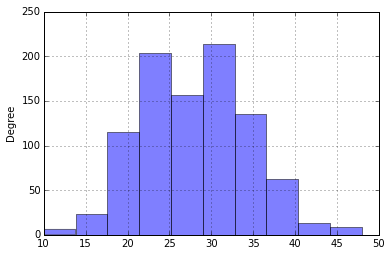

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
original.score.plot(kind='hist', alpha=0.5)

Now let's use gatherplot for interactive exploration.

https://gatherplot-dev.firebaseapp.com/#/ 



In [70]:
import dropbox
import re
import time
from firebase import firebase
from IPython.display import IFrame

def publish_gatherplot(p, dataname):
    
    filename = str(time.time())+'.csv'
    p.index.name = 'indexPandas'
    p.to_csv(filename)
    access_token = 'vwezSddRAD0AAAAAAAA0K2kAPqcpKnsShlfAPyIxSAYG0l2GxKfx5vtEkSyCeNOk'
    client = dropbox.client.DropboxClient(access_token)
    f = open(filename,'rb')
    response = client.put_file('./gatherplot/' + filename,f)
    print "uploaded:", response
    
    response = client.share('./gatherplot/' + filename, short_url=False)
    print 'Shared:', response
    url = response['url']
    match = re.search(r'https://www\.dropbox\.com/s/(.+)\?dl=0', url)
    if match:
#     print match.group(1)
        download_url = 'https://dl.dropboxusercontent.com/s/' + match.group(1)
        print download_url
        
    aFirebase = firebase.FirebaseApplication('https://gatherplot-dev.firebaseio.com',None)
    
    new_csv = {'name':dataname, 
           'uploader':"google:110953151430048855242", 
           'uploaderName': "Deok Gun Park",
           'url': download_url } 

    result = aFirebase.post('/csv',new_csv)
    print result
    

    return 'https://gatherplot-dev.firebaseapp.com/#/load/' + result['name']

In [71]:
# url = publish_gatherplot(original, "CES-D survey exploration - 939 filtered ")
url = u'https://gatherplot-dev.firebaseapp.com/#/load/-Jnisp3oVpf5W0h07lRP'

In [72]:
IFrame(url, 900,1200)

## Open IE 

We will analyze the result of Open IE. 

Open IE http://openie.allenai.org/
Open IE GitHub https://github.com/knowitall/openie

### Depressed Case 

We ran the reddit depressed.txt file and get the result.  


In [2]:
import pandas as pd
ieDepressed = pd.read_csv('../other_data/ie-depressed_trimmed.csv')


In [9]:
ieDepressed.head()
len(ieDepressed)

64213

The format is not so friendly to process.  Let's try human readable format.  
We ran the reddit depressed.txt and get the result as readable-ie-depressed.


In [30]:
import codecs
import re

f = codecs.open('../other_data/readable-ie-depressed.txt', 'rU', 'utf-8')

subject = []
relation = []
argument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        subject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        relation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        argument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [60]:
from nltk import *

lemmatizer = stem.WordNetLemmatizer()

lemaRelation = [ lemmatizer.lemmatize(word, pos='v') for phrase in relation for word in tokenize.word_tokenize(phrase)]

lemaRelationDist = FreqDist(lemaRelation)

relationDist = FreqDist(relation)
subjectDist = FreqDist(subject)
argumentDist = FreqDist(argument)

# relationDist.most_common(20)

for i,j in relationDist.most_common(20):
    print '* '  +  i




* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started


#### Lemmatization

I tried running lemmatization on the relationship data.  However the data was actually hard to get meaningful insight with lemmatization because it loses the the context like **don't know**.  You can see that **don't know** in the orginal data is replaced with **do** and **n't** in the lemmatized version. 

##### Top 20 words with lemmatization
* be
* to
* do
* n't
* have
* 'm
* want
* just
* get
* feel
* know
* 've
* 's
* try
* not
* go
* think
* can
* ca
* make



##### Top 20 words without lemmatization 

* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started

### Non Depressed Case 

Now I will do same for Non-depressed case.  First I will read the json file format. 

The raw data is too big in the sense it contains 800MB of text.   I will downsample it with 40MB of text which is 5% of total data.  

#### Segment original data into 400kb

In [16]:
import json
import codecs

numFiles = 100;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%2000 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)
        
# fSource.close()
# fDestination.close()
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


#### Run the open ie on the segmented data

In [2]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call
import os

numFiles = 100

os.chdir('/Users/intuinno/codegit/openie/')

os.getcwd()

numProcess = 4;

pool = Pool(numProcess)

commands = [ "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_materials/reddit/segNDepression" + str(i)  + ".txt ../cl2_final/project_materials/reddit/ie-segNDepression" + str(i)  + ".txt '" for i in range(numFiles)] 

for i, returncode in enumerate(pool.imap(partial(call, shell=True), commands)):
    print i
    print returncode
    if returncode != 0:
       print("%d command failed: %d" % (i, returncode))

0
0
1
0
2
0
3
1
3 command failed: 1
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0


#### Now combine this data into a single file again

In [11]:
#### Now combine this data into a single file again.  
import codecs

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

fDestination  = codecs.open('../project_materials/reddit/ie-NDepression.txt', mode = 'w', encoding='utf-8')

for num in range(numFiles):
    print num
    
    fSource = codecs.open('../project_materials/reddit/ie-segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

#     for i,line in enumerate(fSource):
    fDestination.write( fSource.read())
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Now Let's run the extraction of tuple for the Non depressed case


In [19]:
import codecs
import re

f = codecs.open('../other_data/ie-NDepression.txt', 'rU', 'utf-8')

NDsubject = []
NDrelation = []
NDargument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        NDsubject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        NDrelation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        NDargument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [21]:
import pandas as pd

NDtuple = pd.DataFrame({'subject':NDsubject, 'relation':NDrelation, 'argument':NDargument   })
NDtuple.to_csv('../other_data/NDtuples.csv', encoding='utf-8')

### Comparing KL divergence key contributors.  



In [67]:
from nltk import *

NDRelDist = FreqDist(NDrelation)
NDSubDist = FreqDist(NDsubject)
NDArguDist = FreqDist(NDargument)

NDRelDist.most_common(50)

NDRelDist['is']
print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))


    
    

0.0
1.24351816158e-05


In [52]:
klContributionRelDepressedToNonDepressed

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

### Now let's compare the words that is different from depressed and nondepressed people



In [53]:

print 'KL Divergence key contributor from depressed to nondepressed'
for i in range(30):
    print str(i) + '. ' + sorted_klDepressedToNonDepressed[i][0] 

KL Divergence key contributor from depressed to nondepressed
0. feel
1. 'm
2. do n't know
3. was
4. hate
5. am
6. do n't want
7. know
8. felt
9. just feel
10. to be
11. wish
12. feels
13. 've been
14. do n't know what to do to do
15. just want
16. do n't feel
17. to die
18. do
19. just need
20. told
21. 'm not
22. just wish
23. lost
24. try
25. started
26. wake up
27. to talk
28. had
29. do n't have


In [54]:
print 'KL Divergence key contributor from nondepressed to depressed'
for i in range(30):
    print str(i) + '. ' + sorted_klNonDepressedToDepressed[i][0] 

KL Divergence key contributor from nondepressed to depressed
0. is
1. are
2. has
3. 'm looking
4. was wondering
5. would like
6. would be
7. used
8. have
9. looks
10. 'd like
11. bought
12. will be
13. use
14. to play
15. to use
16. 're
17. looked
18. am looking
19. says
20. like
21. saw
22. included
23. run
24. play
25. looking
26. include
27. found
28. can get
29. plan


In [59]:
for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.002344969970

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | NonDepressed to Depressed | KLD score
------------ | ------------- | ------------ | -------------
feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.00234496997024 | am looking | 0.00186020227527
just need | 0.00232457533705 | says | 0.00162288714766
told | 0.00220530714892 | like | 0.00156547427076
'm not | 0.00220190139767 | saw | 0.00153061678674
just wish | 0.00219190453379 | included | 0.00151216917483
lost | 0.00209698332496 | run | 0.00148758905607
try | 0.00202329517571 | play | 0.00148171079383
started | 0.00197291885473 | looking | 0.00145494111641
wake up | 0.00184614958337 | include | 0.00144461132393
to talk | 0.00176865571138 | found | 0.00140188467898
had | 0.00173806268442 | can get | 0.0013639326444
do n't have | 0.00170597871196 | plan | 0.00127646126076


## The difference 'I' and 'me' usage pattern among the depressed people and nondepressed people.  



In [64]:
print subjectDist.freq('i')
print NDSubDist.freq('i')

0.549964961458
0.34516400597


In [68]:
print argumentDist.freq('me')
print NDArguDist.freq('me')

0.0298372654364
0.0148098605007


# LIWC Analysis

Now we will do LIWC analysis.  

## Build dictionary

I will build the category distribution of LIWC category.  To do that I will begin with liwc.dic file.  

From the liwc.dic file, I will extract the category and the words definition.  

* **liwc_def** : definition of category
* **liwc_words** : the words , and liwc category list tuple. 
* **getLIWC_Str** : get the string version of the liwc definition for words.  (ex: getLIWC_Str('abandons') returns ['affect', 'negemo', 'sad', 'cogmech', 'inhib'] 
* **getLIWC_Id** : get the numeric id version of the liwc definition for words. (ex: getLIWC_Id('affect') returns ['131', '133']

In [45]:

import pandas as pd
import re
import fnmatch


liwc_def = {}

for line in open('../other_data/liwc_defs.txt'):
    lineSplit = line.split()
    liwc_def[lineSplit[0]] = lineSplit[1]


liwc_words = []

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()
    liwc_words.append( (lineSplit[0],  lineSplit[1:len(lineSplit)] ) )

liwc_wordsExact = {}
liwc_wordsWild = {}

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()

    if lineSplit[0].endswith('*'):
        liwc_wordsWild[  lineSplit[0].rstrip('*') ] =   lineSplit[1:len(lineSplit)]
    else:
        liwc_wordsExact[lineSplit[0]] = lineSplit[1:len(lineSplit)]


def getLIWC_Id(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return catList

def getLIWC_Str(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return [liwc_def[catId] for  catId in catList ]

def getLIWC_IdFast(w):
        if w in liwc_wordsExact:
            # print w + ' : ' + str(catList)
            return liwc_wordsExact[w]
        else:
            for key, value in liwc_wordsWild.iteritems():
                if w.startswith(key):
                    return value



print getLIWC_Str('abandons')
print getLIWC_Id('affect')

print getLIWC_IdFast('abandons')
print getLIWC_IdFast('affect')



['affect', 'negemo', 'sad', 'cogmech', 'inhib']
['131', '133']
['125', '127', '130', '131', '137']
['131', '133']


### Let's run the code for the depressed case.  

In [46]:
import codecs
import re
from nltk import *

f = codecs.open('../project_materials/reddit/depressed.txt', 'rU', 'utf-8')

depressedAllText = word_tokenize(f.read())


liwcDist = FreqDist()



        

In [47]:
for (i,w) in enumerate(depressedAllText):
    wlower = w.lower()
    if i%10000 == 0:
        print i
    catList =  getLIWC_IdFast(wlower)
    if catList:
        for cat in catList:
            liwcDist[cat] += 1


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


In [48]:
liwcDist

FreqDist({'1': 263066, '2': 86637, '131': 84862, '11': 65150, '3': 60780, '250': 57242, '17': 53602, '4': 47228, '14': 38707, '12': 35839, ...})

## Now we will build a 80MB version of undepressed posts. 



In [5]:
import json
import codecs

numFiles = 1;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/nondepressed80MB' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%10 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)

0


In [6]:
import multiprocessing as mp

def liwcMPparse(num):
    print num

    f = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

    depressedAllText = word_tokenize(f.read())


    liwcDist = FreqDist()

    for (i,w) in enumerate(depressedAllText):
        wlower = w.lower()
        catList =  getLIWC_IdFast(wlower)
        if catList:
            for cat in catList:
                liwcDist[cat] += 1

    return liwcDist


# pool = mp.Pool(processes=6)

# result = pool.map(liwcMPparse, range(100))

# liwcNDDist = reduce(lambda x, y: x+y, result)


In [49]:
import pickle

output = open('liwcNDDist.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcNDDist = pickle.load(output)

output.close()

In [50]:
FreqDist(liwcNDDist).N()


34225101

In [73]:
depressedProbDist = LaplaceProbDist( liwcDist )
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcNDDist))

numTokenDepressed = float(liwcDist.N())
numTokenNonDepressed = float(FreqDist(liwcNDDist).N())

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcDist.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcNDDist.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + str(liwcDist[sorted_klLIWC_D_ND[i][0]]/numTokenDepressed) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) + ' | ' + str(liwcDist[ sorted_klLIWC_ND_D[i][0]]/numTokenNonDepressed) 

chartData = []
for i in range(30):
    cat = sorted_klLIWC_D_ND[i][0]
    chartData.append( {} )
    chartData[i]['cat'] = liwc_def[cat] 
    chartData[i]['Depressed'] = depressedProbDist.prob(cat)
    chartData[i]['NonDepressed'] = nondepressedProbDist.prob(cat)
chartData2 = []
for i in range(30):
    cat = sorted_klLIWC_ND_D[i][0]
    chartData2.append( {} )
    chartData2[i]['cat'] = liwc_def[cat] 
    chartData2[i]['Depressed'] = depressedProbDist.prob(cat)
    chartData2[i]['NonDepressed'] = nondepressedProbDist.prob(cat)


i | 0.0208665925728 | 0.0366498037837 | relativ | 0.0177207821761 | 0.00167251515196
pronoun | 0.0165580015273 | 0.0672319185739 | posemo | 0.0151792810152 | 0.00045153993848
cogmech | 0.015845635606 | 0.0658544856588 | you | 0.0128435742538 | 8.59603014758e-05
funct | 0.0155543008314 | 0.204144094227 | assent | 0.00975881838356 | 1.75017745017e-05
ppron | 0.0130561405473 | 0.0471664070885 | time | 0.00907626200193 | 0.000766338132939
conj | 0.00694948995191 | 0.0248434576593 | affect | 0.00905132183448 | 0.000938726229033
insight | 0.00608261482109 | 0.0106849993287 | leisure | 0.0083593879691 | 9.99558774129e-05
past | 0.00607566536784 | 0.0141150012921 | article | 0.00790607287418 | 0.000572445352316
sad | 0.00493539858818 | 0.00455290079612 | present | 0.00761009754511 | 0.00113095356534
excl | 0.00433005323332 | 0.0126110773543 | social | 0.00674140651099 | 0.00102521246029
negemo | 0.00405417640871 | 0.012703423561 | bio | 0.00570899760194 | 0.000303052429268
ipron | 0.0035521491

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | Absolute Frequency | NonDepressed to Depressed | KLD score | Absolute Frequency
----------------|---------|-------------|----------------
i | 0.0297223407593 | 0.0366498037837 | article | 0.0188451679091 | 0.00113390358405
ppron | 0.0200478226323 | 0.0471664070885 | funct | 0.0121146129348 | 0.0152251674276
pronoun | 0.0190746365626 | 0.0672319185739 | preps | 0.0118820307886 | 0.00310226112251
negemo | 0.0115120514733 | 0.012703423561 | space | 0.00972325748048 | 0.00128750608058
sad | 0.00819327062349 | 0.00455290079612 | relativ | 0.00943656745716 | 0.00331292920366
affect | 0.00677807591567 | 0.0249319237733 | money | 0.00603035430839 | 9.76944288421e-05
health | 0.00474421769244 | 0.00398563124064 | leisure | 0.00583158380293 | 0.000197993270775
bio | 0.00363245390444 | 0.00804886433566 | social | 0.00489509464607 | 0.00203074770095
past | 0.00344426103127 | 0.0141150012921 | tentat | 0.00442704103531 | 0.000808351947652
adverb | 0.0030219613743 | 0.0207259032662 | you | 0.00435462688474 | 0.000170270740316
feel | 0.00290326564529 | 0.00380326688287 | see | 0.00415504982348 | 0.000118413981878
verb | 0.00262749086973 | 0.0505576081246 | quant | 0.00373701288603 | 0.000759504733231
anx | 0.00247461716498 | 0.00218371618208 | achieve | 0.00343759263368 | 0.000415085570886
insight | 0.0024269920569 | 0.0106849993287 | incl | 0.00316966835962 | 0.00122841484133
family | 0.0021878415283 | 0.00187098070896 | work | 0.0030210406991 | 0.000426834367719
time | 0.00206420288525 | 0.0203534143652 | posemo | 0.00262936828665 | 0.000894413331354
present | 0.001796323292 | 0.0300373497725 | future | 0.00253504445006 | 0.000171775512324
negate | 0.00145195699011 | 0.00462662255777 | auxverb | 0.0025211185846 | 0.00207421246165
friend | 0.00144378097066 | 0.00153962079078 | we | 0.00245000031214 | 9.1906844195e-05
certain | 0.00132255539141 | 0.00567657564745 | cogmech | 0.00217265965231 | 0.00491146008317
anger | 0.00113611303231 | 0.00326005390225 | motion | 0.00198018212719 | 0.000425503223251
swear | 0.000941253493055 | 0.00118963642755 | conj | 0.00166383895428 | 0.0018528373489
death | 0.00078745052477 | 0.00110272235065 | number | 0.00158569006813 | 0.000155686027005
filler | 0.000763096871914 | 0.0019765192309 | percept | 0.00141067668628 | 0.000548547272847
excl | 0.000572189786165 | 0.0126110773543 | discrep | 0.00133501658561 | 0.000505603394766
sexual | 0.000453606382195 | 0.00131457541309 | inhib | 0.000834263117877 | 0.000114767803551
shehe | 0.00023569904543 | 0.00487572451031 | relig | 0.000743072070393 | 2.69122686087e-05
home | 0.000138698325475 | 0.00152953254971 | they | 0.000728530190696 | 0.000158521943482
humans | 6.94670700563e-05 | 0.00249257156249 | cause | 0.000579561156327 | 0.000465263929776
ipron | -4.71619196513e-05 | 0.0200655114855 | ingest | 0.000464977399827 | 7.35023250174e-05

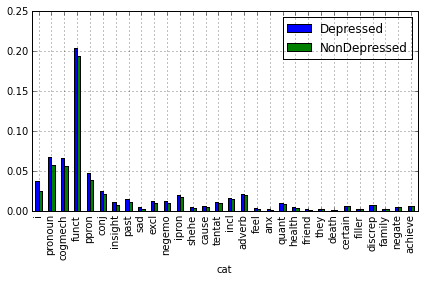

In [79]:
chartDataDF = pd.DataFrame(chartData)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['Depressed','NonDepressed']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()

plt.savefig('liwcReddit.pdf')

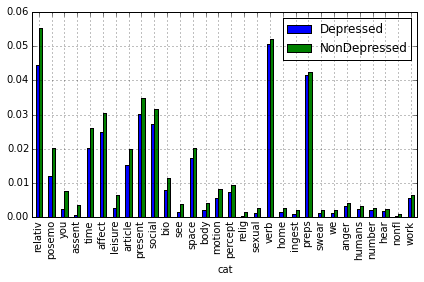

In [78]:
chartDataDF = pd.DataFrame(chartData2)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['Depressed','NonDepressed']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()
plt.savefig('liwcReddit2.pdf')

In [7]:
import pandas as pd
featureLIWCDF = pd.read_csv('liwcDepressionAll.csv',index_col=0)
featureLIWCDF['sum'] = featureLIWCDF.sum(axis=1)

newFeatureLIWC = featureLIWCDF.divide(featureLIWCDF['sum'], axis='index')

newFeatureLIWC.to_csv('newLiwcDepressionAll.csv')


##Application to facebook data

In this section I will try to apply the openIE and LIWC to facebook dataset.  I will use the dataset cleaned by Rashmi. 

The dataset files are following. 
* ../other_data/Depression_statuswise_tokens/ 
* ../other_data/neuroticism_tokenized/ 
* ../mypersonality_depression/939_userScores.csv
* ../mypersonality_neuroticism/userDictionary.csv 


### From the Neuroticism dataset make high score group and low score group

I will parse userDictionary.csv file to find people with high neurotism score and low score.  

In [19]:
import pandas as pd
import os

os.getcwd()
os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

neuroticism = pd.read_csv('../project_materials/mypersonality_neuroticism/userDictionary.csv', escapechar='\\')



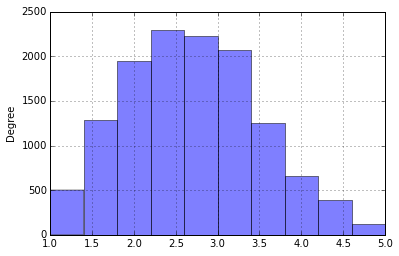

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
neuroticism.neu.plot(kind='hist', alpha=0.5)

In [22]:
# top_neu = neuroticism[neuroticism.neu >= neuroticism.neu.quantile(2.0/3)]
# bottom_neu = neuroticism[neuroticism.neu <= neuroticism.neu.quantile(1.0/3)]

top_neu = neuroticism[  neuroticism.neu <= 5.0  ].dropna()
top_neu = top_neu[top_neu.neu >=3.05].dropna()

bottom_neu = neuroticism[  neuroticism.neu <= 2.25  ].dropna()
# bottom_neu = top_neu[top_neu.neu >=3.05].dropna()



### Here we will do gender wise analysis

In [28]:
maleNeu = top_neu[top_neu.gender == 0].dropna()
len(maleNeu)
femaleNeu = top_neu[top_neu.gender == 1].dropna()
len(femaleNeu)



2754

### Let's create an aggregated dataset for neuroticism

I will iterate over top_neu and bottom_neu to create a text file.  

In [29]:
import multiprocessing as mp
import codecs
from nltk import *

def liwcMPparseFileName(filename):
    
#     print filename

    f = codecs.open(filename,mode='r',encoding='cp1252')

    depressedAllText = word_tokenize(f.read())

    liwcDist = FreqDist()

    for (i,w) in enumerate(depressedAllText):
        wlower = w.lower()
        catList =  getLIWC_IdFast(wlower)
        if catList:
            for cat in catList:
                liwcDist[cat] += 1

    return liwcDist
    

In [30]:
pool = mp.Pool(processes=1)

a = '../other_data/neuroticism_tokenized/' + maleNeu['userid'] + '_d_tokens.txt'
b = a.values.tolist()

result = pool.map(liwcMPparseFileName, b)



In [31]:
maleDistNeu = reduce(lambda x, y: x+y, result)

import pickle

output = open('maleDistNeu.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(maleDistNeu, output)

output.close()


In [32]:
pool = mp.Pool(processes=1)

a = '../other_data/neuroticism_tokenized/' + femaleNeu['userid'] + '_d_tokens.txt'
b = a.values.tolist()

resultFemaleNeu = pool.map(liwcMPparseFileName, b)

In [34]:
femaleDistNeu = reduce(lambda x, y: x+y, resultFemaleNeu)

import pickle

output = open('femaleDistNeu.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(femaleDistNeu, output)

output.close()


In [44]:
maleNeu


,userid,n_status,gender,neu
1,861957e6f5f77768ad85b497623688f9,31,0,3.35
2,2dc31ea483d5f518d4ca30d4e850e4a7,49,0,3.55
3,fabdbdf53562be91ebbabd5e185e01b7,215,0,3.25
4,441f67f698b2faa8c5eb8086723b7c3f,348,0,3.80
12,78a4c26da672fca4d9fd4bdeb88592e7,289,0,3.75
13,e9dd6322d8c6187a28e148cf511cb9bd,89,0,3.50
15,433421dfb7f37c978bda2fba25f7c8e4,84,0,3.60
21,999bf7a3988bd2a20a65d624cdd91777,183,0,3.35
31,62e256828a5a42cc8f14cbc8db33e04f,79,0,3.75
32,859cfb627bede1baa30b5c74c0a329a8,8,0,3.45


In [92]:
liwcTopNeu = maleDistNeu
liwcBottomNeu = femaleDistNeu


depressedProbDist = LaplaceProbDist( FreqDist(liwcTopNeu) )
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcBottomNeu))

numTokenDepressed = float(FreqDist(liwcTopNeu).N())
numTokenNonDepressed = float(FreqDist(liwcBottomNeu).N())

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcTopNeu.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcBottomNeu.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + str(liwcTopNeu[sorted_klLIWC_D_ND[i][0]]/numTokenDepressed) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) + ' | ' + str(liwcBottomNeu[ sorted_klLIWC_ND_D[i][0]]/numTokenNonDepressed) 

chartData = []
for i in range(30):
    cat = sorted_klLIWC_D_ND[i][0]
    chartData.append( {} )
    chartData[i]['cat'] = liwc_def[cat] 
    chartData[i]['Female'] = depressedProbDist.prob(cat)
    chartData[i]['Male'] = nondepressedProbDist.prob(cat)
chartData2 = []
for i in range(30):
    cat = sorted_klLIWC_ND_D[i][0]
    chartData2.append( {} )
    chartData2[i]['cat'] = liwc_def[cat] 
    chartData2[i]['Female'] = depressedProbDist.prob(cat)
    chartData2[i]['Male'] = nondepressedProbDist.prob(cat)


funct | 0.00483914753581 | 0.196055552045 | ppron | 0.00460898606252 | 0.0397648460833
article | 0.00427692855715 | 0.0220167031863 | i | 0.00409005717146 | 0.0254273896032
preps | 0.00299125301286 | 0.0440802650568 | posemo | 0.0034807669549 | 0.02081251967
space | 0.00218969463655 | 0.0212550346217 | pronoun | 0.00287581837219 | 0.0572110648213
anger | 0.00217908131393 | 0.00499034238222 | social | 0.00218032878449 | 0.0319731174246
swear | 0.00185668830545 | 0.00270866838367 | affect | 0.00172305886817 | 0.0309225779276
negemo | 0.00169896501364 | 0.0109956696557 | home | 0.00169015610849 | 0.00304006387665
ipron | 0.00165247014699 | 0.0185570061686 | family | 0.00155269005809 | 0.0019790109592
cogmech | 0.00160078934259 | 0.0565359696287 | time | 0.00130088219823 | 0.0261805437597
tentat | 0.000996405088214 | 0.00986171099541 | present | 0.00120384173431 | 0.0351567978352
achieve | 0.000910096095346 | 0.00604756457363 | bio | 0.00114561316827 | 0.0116009174605
insight | 0.000848279

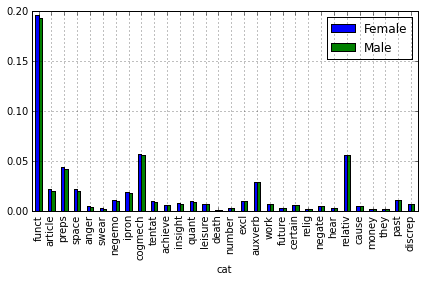

In [93]:
chartDataDF = pd.DataFrame(chartData)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['Female','Male']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()

plt.savefig('liwcGender1.pdf')

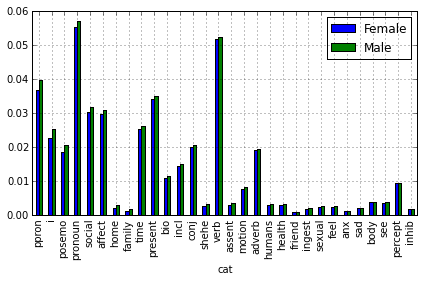

In [94]:
chartDataDF = pd.DataFrame(chartData2)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['Female','Male']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()

plt.savefig('liwcGender2.pdf')

In [40]:
len(femaleNeu)

2754

So here is the comparison of top key differentiators according to Neurocism score.   

Female | KLD score | Absolute Frequency | Male | KLD score | Absolute Frequency
----------------|---------|-------------|----------------
funct | 0.00483914753581 | 0.196055552045 | ppron | 0.00460898606252 | 0.0397648460833
article | 0.00427692855715 | 0.0220167031863 | i | 0.00409005717146 | 0.0254273896032
preps | 0.00299125301286 | 0.0440802650568 | posemo | 0.0034807669549 | 0.02081251967
space | 0.00218969463655 | 0.0212550346217 | pronoun | 0.00287581837219 | 0.0572110648213
anger | 0.00217908131393 | 0.00499034238222 | social | 0.00218032878449 | 0.0319731174246
swear | 0.00185668830545 | 0.00270866838367 | affect | 0.00172305886817 | 0.0309225779276
negemo | 0.00169896501364 | 0.0109956696557 | home | 0.00169015610849 | 0.00304006387665
ipron | 0.00165247014699 | 0.0185570061686 | family | 0.00155269005809 | 0.0019790109592
cogmech | 0.00160078934259 | 0.0565359696287 | time | 0.00130088219823 | 0.0261805437597
tentat | 0.000996405088214 | 0.00986171099541 | present | 0.00120384173431 | 0.0351567978352
achieve | 0.000910096095346 | 0.00604756457363 | bio | 0.00114561316827 | 0.0116009174605
insight | 0.000848279257147 | 0.0076134614252 | incl | 0.00101287092867 | 0.0151758415722
quant | 0.000676864037481 | 0.00932584540159 | conj | 0.000989388955704 | 0.0206475954022
leisure | 0.000638579229834 | 0.00679902310391 | shehe | 0.000875742239818 | 0.00320683401223
death | 0.00062984047387 | 0.00106872191434 | verb | 0.000789359473128 | 0.052431752151
number | 0.000568534290063 | 0.00302722145629 | assent | 0.000672854164389 | 0.00352019012116
excl | 0.00051202395402 | 0.010194235694 | motion | 0.000541666359272 | 0.00818241057403
auxverb | 0.000496961106618 | 0.0286512909997 | adverb | 0.000524720925171 | 0.0194467380688
work | 0.000493923446703 | 0.00658267784913 | humans | 0.000476429721555 | 0.00331883002965
future | 0.000449068786031 | 0.00303162789218 | health | 0.00046671913 | 0.00321682577444
certain | 0.000446424653208 | 0.00559208956629 | friend | 0.000309814719864 | 0.00105808347808
relig | 0.000444527911356 | 0.00179288203692 | ingest | 0.000270307685499 | 0.00208422541913
negate | 0.000423080412609 | 0.00486535006661 | sexual | 0.000194795237166 | 0.002627753207
hear | 0.000410021394355 | 0.00247856645099 | feel | 0.000167588511795 | 0.00268678084643
relativ | 0.00040288772615 | 0.0556399585064 | anx | 0.000156225686521 | 0.00122605744043
cause | 0.000368620373691 | 0.00499958515018 | sad | 0.000155794382204 | 0.00217675957039
money | 0.000304008072052 | 0.00198364846873 | body | 0.000114626097731 | 0.00403936048067
they | 0.00021207473047 | 0.0018289933164 | see | 0.000110522383629 | 0.00383759911357
past | 8.73598211926e-05 | 0.0105178400468 | percept | 7.54638387583e-05 | 0.00948314540193
discrep | 5.70416563009e-05 | 0.00662824684467 | inhib | -7.77410455047e-06 | 0.00196079304737


### Let's make CSV version. 


In [45]:

pool = mp.Pool(processes=7)

a = '../other_data/neuroticism_tokenized/' + neuroticism['userid'] + '_d_tokens.txt'
b = a.values.tolist()

result = pool.map(liwcMPparseFileName, b)

In [46]:

import pickle

output = open('liwcNeuAllResult.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(result, output)

output.close()

In [80]:
ids = neuroticism['userid'].values.tolist()

featureLIWC = {}

for index,id in enumerate(ids):
    featureLIWC[id] = result[index] 

featureLIWCDF = pd.DataFrame(featureLIWC)
featureLIWCDF = featureLIWCDF.T.fillna(value=0)

featureLIWCDF.columns = [liwc_def[i] for i in featureLIWCDF.columns.values]

featureLIWCDF.to_csv('liwcNeuroticismAll.csv')


### Now we will get the top contributors

In [78]:
topKL = [ liwc_def[sorted_klLIWC_D_ND[i][0]] for i in range(15)]
bottomKL = [ liwc_def[sorted_klLIWC_ND_D[i][0]] for i in range(15)]
neuKLnames = topKL + bottomKL     
featureLIWCDFKL = featureLIWCDF[neuKLnames]
featureLIWCDFKL.to_csv('liwcNeuroticism30.csv')

In [81]:
import pandas as pd

neuroticism = pd.read_csv('../project_materials/mypersonality_depression/939_userScores.csv', escapechar='\\')


In [82]:
pool = mp.Pool(processes=7)

a = '../other_data/Depression_statuswise_tokens/' + neuroticism['userid'] + '_d_tokens.txt'
b = a.values.tolist()

result = pool.map(liwcMPparseFileName, b)

In [83]:
ids = neuroticism['userid'].values.tolist()

featureLIWC = {}

for index,id in enumerate(ids):
    featureLIWC[id] = result[index] 

featureLIWCDF = pd.DataFrame(featureLIWC)
featureLIWCDF = featureLIWCDF.T.fillna(value=0)

featureLIWCDF.columns = [liwc_def[i] for i in featureLIWCDF.columns.values]

featureLIWCDF.to_csv('liwcDepressionAll.csv')

featureLIWCDFKL = featureLIWCDF[neuKLnames]
featureLIWCDFKL.to_csv('liwcDepression30.csv')

In [12]:
import pandas as pd
featureLIWCDF = pd.read_csv('liwcDepressionAll.csv',index_col=0)
featureLIWCDF['sum'] = featureLIWCDF.sum(axis=1)

newFeatureLIWC = featureLIWCDF.divide(featureLIWCDF['sum'], axis='index')

newFeatureLIWC.to_csv('newLiwcDepressionAll.csv')


In [15]:
import pandas as pd
featureLIWCDF30 = pd.read_csv('liwcDepression30.csv',index_col=0)

newFeatureLIWC30 = featureLIWCDF30.divide(featureLIWCDF['sum'], axis='index')

newFeatureLIWC30.to_csv('newLiwcDepression30.csv')


In [16]:
import pandas as pd
featureLIWCDF = pd.read_csv('liwcNeuroticismAll.csv',index_col=0)
featureLIWCDF['sum'] = featureLIWCDF.sum(axis=1)

newFeatureLIWC = featureLIWCDF.divide(featureLIWCDF['sum'], axis='index')

newFeatureLIWC.to_csv('newLiwcNeuroticismAll.csv')

In [17]:
import pandas as pd
featureLIWCDF30 = pd.read_csv('liwcNeuroticism30.csv',index_col=0)

newFeatureLIWC30 = featureLIWCDF30.divide(featureLIWCDF['sum'], axis='index')

newFeatureLIWC30.to_csv('newLiwcNeuroticism30.csv')


## OpenIE for facebook data


### Data Cleaning 
What I found on the data is that it contains lots of \ and \" .  So I will remove them.  


1. Get the key different phrases between topNeu and bottomNeu
2. Get the feature file with this count.  

In [8]:
test = '\What is wrong with you?!\"\ '
print test

testfiltered = test.replace('\"','').replace('\\','')
print testfiltered
                                             
                                            


\What is wrong with you?!"\ 
What is wrong with you?! 


In [19]:


# a = '../other_data/neuroticism_tokenized/' + top_neu['userid'] + '_d_tokens.txt'
# b = a.values.tolist()

import codecs

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')
# os.mkdir('../project_materials/mypersonality_neuroticism/text/step3')

# topIDs = topIDs[0:2]
def clearFile(id):
    fSource = codecs.open('../project_materials/mypersonality_neuroticism/text/step2/' + id + '_step2.txt',mode='r',encoding='utf-8')

    fDestination = codecs.open('../project_materials/mypersonality_neuroticism/text/step3/' + id + '_step3.txt',mode='w',encoding='utf-8')

    contents = fSource.read()
    
    contentsFiltered = contents.replace('\"','').replace('\\','')
    
#     for i,line in enumerate(fSource):
    fDestination.write( contentsFiltered)
    

In [20]:
import os
os.getcwd()

'/Users/intuinno/codegit/cl2_final/notebook'

In [21]:
import multiprocessing as mp

pool = mp.Pool(processes=6)

neuIDs = neuroticism['userid'].values.tolist()

result = pool.map(clearFile, neuIDs)


In [ ]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call
import os


os.chdir('/Users/intuinno/codegit/openie/')

os.getcwd()

numProcess = 3;

pool = Pool(numProcess)


commands = [ "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_materials/mypersonality_neuroticism/text/step3/" + id  + "_step3.txt ../cl2_final/project_materials/mypersonality_neuroticism/text/openie/" + id  + "_openie.txt '" for id in topList] 

# pool.imap(partial(call, shell=True), commands[0:2])

for i, returncode in enumerate(pool.imap(partial(call, shell=True), commands)):
    print i
    print returncode
    if returncode != 0:
       print("%d command failed: %d" % (i, returncode))

In [24]:
commands

["sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_material/mypersonality_neuroticism/text/step3/861957e6f5f77768ad85b497623688f9_step3.txt ../cl2_final/project_material/mypersonality_neuroticism/text/openie/861957e6f5f77768ad85b497623688f9_openie.txt '",
 "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_material/mypersonality_neuroticism/text/step3/2dc31ea483d5f518d4ca30d4e850e4a7_step3.txt ../cl2_final/project_material/mypersonality_neuroticism/text/openie/2dc31ea483d5f518d4ca30d4e850e4a7_openie.txt '",
 "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_material/mypersonality_neuroticism/text/step3/fabdbdf53562be91ebbabd5e185e01b7_step3.txt ../cl2_final/project_material/mypersonality_neuroticism/text/openie/fabdbdf53562be91ebbabd5e185e01b7_openie.txt '",
 "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_material/myperson

### Let's create a chart for LIWC Neuroticism

In [80]:
import pickle

output = open('liwcBottomNeu.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcNDDist = pickle.load(output)

output.close()


output = open('liwcTopNeu.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcDist = pickle.load(output)

output.close()

In [88]:
depressedProbDist = LaplaceProbDist( FreqDist(liwcDist ))
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcNDDist))

numTokenDepressed = float(FreqDist(liwcDist).N())
numTokenNonDepressed = float(FreqDist(liwcNDDist).N())

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcDist.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcNDDist.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + str(liwcDist[sorted_klLIWC_D_ND[i][0]]/numTokenDepressed) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) + ' | ' + str(liwcDist[ sorted_klLIWC_ND_D[i][0]]/numTokenNonDepressed) 

chartData = []
for i in range(30):
    cat = sorted_klLIWC_D_ND[i][0]
    chartData.append( {} )
    chartData[i]['cat'] = liwc_def[cat] 
    chartData[i]['High Neuroticism Score'] = depressedProbDist.prob(cat)
    chartData[i]['Low Neuroticism Score'] = nondepressedProbDist.prob(cat)
chartData2 = []
for i in range(30):
    cat = sorted_klLIWC_ND_D[i][0]
    chartData2.append( {} )
    chartData2[i]['cat'] = liwc_def[cat] 
    chartData2[i]['High Neuroticism Score'] = depressedProbDist.prob(cat)
    chartData2[i]['Low Neuroticism Score'] = nondepressedProbDist.prob(cat)


i | 0.00282938886271 | 0.0246980717456 | relativ | 0.00318457349249 | 0.0679691620257
ppron | 0.00267635317635 | 0.0389303160858 | article | 0.00212949412778 | 0.0245176784081
pronoun | 0.00240181235494 | 0.05667851791 | preps | 0.00208026807335 | 0.0522368629489
negemo | 0.00221129733922 | 0.0101825265614 | posemo | 0.00165977313043 | 0.0247580895983
adverb | 0.000989311382508 | 0.0193487814689 | space | 0.001553279819 | 0.0247522145521
anger | 0.00094784585952 | 0.0040414197755 | time | 0.00120480093307 | 0.0318035238384
bio | 0.000818482667599 | 0.0113922527212 | funct | 0.00116601346538 | 0.237406426455
cogmech | 0.000566872006315 | 0.0557357887709 | leisure | 0.00103932579177 | 0.00795348711577
conj | 0.000544400283461 | 0.0204642201056 | achieve | 0.000753812166191 | 0.0068799298892
sad | 0.000528000970531 | 0.00214810176893 | relig | 0.000635681305539 | 0.00194550006208
swear | 0.00049699297458 | 0.00196279917479 | social | 0.000542250074953 | 0.0387089958493
affect | 0.00049583

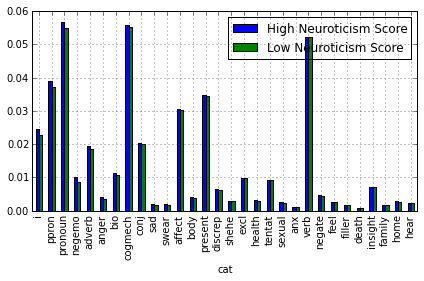

In [89]:
chartDataDF = pd.DataFrame(chartData)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['High Neuroticism Score','Low Neuroticism Score']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()

plt.savefig('liwcNeu1.pdf')

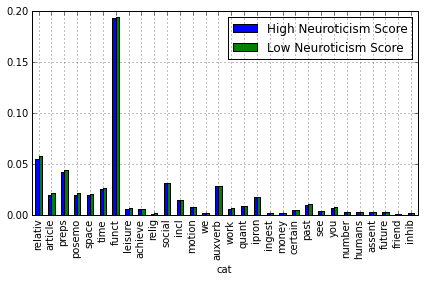

In [90]:
chartDataDF = pd.DataFrame(chartData2)
chartDataDF.head()
chartDataDF.index = chartDataDF.cat

newDF = chartDataDF.loc[:,['High Neuroticism Score','Low Neuroticism Score']]
# newDF = chartDataDF['Depressed','NonDepressed']
newDF.head()

newDF.plot(kind='bar')

plt.tight_layout()
plt.savefig('liwcNeu2.pdf')